somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1813 ip_diffim
#setup -k -r .
setup -t 1813 -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

In [3]:
import lmfit

## Note right now we are only fitting one flux value and the 4 positions, not
##   anything related to the shape of the PSF!
def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, psfWidth): #, sig1, sig2):
    """
    Dipole based on 2-d (potentially [TBD] ellipsoidal) double-gaussian: 
    dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg) #, sig1, sig2)
    """
    if False: #try:
        ## Wow - this is about 3x slower than the below (pure python)...
        generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)

        zout = np.array([generator(x[0][i] - xcenPos, x[1][i] - ycenPos) for i in xrange(len(x[0]))])
        zmax = np.sum(zout)
        zout -= np.array([generator(x[0][i] - xcenNeg, x[1][i] - ycenNeg) for i in xrange(len(x[0]))])
        zout *= flux / zmax ## assume pos and neg lobes have same flux
    else: #except NameError:   ## don't have stack installed, use a custom double gaussian2d generator. 
        def generator(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
            a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
            b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
            c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
            xxc, yyc = x-xc, y-yc
            return offset + np.exp( - (a*(xxc**2) + 2*b*xxc*yyc + c*(yyc**2)))

        #print xcenPos, xcenNeg, ycenPos, ycenNeg
        tmp1 = generator(x[0], x[1], xcenPos, ycenPos, psfWidth, psfWidth)
        tmp1sum = tmp1.sum()
        tmp2 = generator(x[0], x[1], xcenPos, ycenPos, psfWidth*1.75, psfWidth*1.75)
        tmp2sum = tmp2.sum()
        zout = tmp1 * (flux/tmp1sum*0.9)
        zout += tmp2 * (flux/tmp2sum*0.1) 
        tmp1 = generator(x[0], x[1], xcenNeg, ycenNeg, psfWidth, psfWidth)
        tmp2 = generator(x[0], x[1], xcenNeg, ycenNeg, psfWidth*1.75, psfWidth*1.75)
        zout -= tmp1 * (flux/tmp1sum*0.9)
        zout -= tmp2 * (flux/tmp2sum*0.1)

    return zout

def genDipole(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0.0, flux=3000., noise=1., display=False):
    y, x = np.mgrid[:w, :h]
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]

    #z = np.array([generator(in_x[0][i] - xc, in_x[1][i] - yc) for i in np.arange(len(in_x[0]))])
    #z *= ht / z.max()
    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    z = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad), psfWidth) #, psfWidth, psfWidth*1.75)
    ## TBD: accurate (poisson) noise proportional to pixel intensity
    z += np.random.normal(0., noise, x.shape) #* (0.1 + np.sqrt(np.abs(z)))
    if display:
        zptp = z.ptp() / 2.
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray' )#, vmin=-zptp, vmax=zptp)
        plt.title("Data")

    return x.reshape(w, h), y.reshape(w, h), z.reshape(w, h)

def fitDipole(z, psfWidth=2., verbose=False, display=False):
    w, h = z.shape
    y, x = np.mgrid[:w, :h]
    z = z.ravel()
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]
    xc = w / 2  ## Note - this may be a cheat to assume the dipole is centered in center of the image.
    yc = h / 2
    
    gmod = lmfit.Model(dipoleFunc, verbose=verbose)
    maxPos = np.array(np.unravel_index(np.argmax(z), (w,h)))
    minPos = np.array(np.unravel_index(np.argmin(z), (w,h)))
    startingFlux = np.abs(z).sum() / 2. #z.ptp() / 2.  ## ptp = max-min
    
    ## For close/faint dipoles the starting locs (min/max) might be way off, let's help them a bit:
    centroidRange = psfWidth * 2.
    if   minPos[0] < xc-centroidRange: minPos[0] = xc-centroidRange
    elif minPos[0] > xc+centroidRange: minPos[0] = xc+centroidRange
    if   minPos[1] < yc-centroidRange: minPos[1] = yc-centroidRange
    elif minPos[1] > yc+centroidRange: minPos[1] = yc+centroidRange
    if   maxPos[0] < xc-centroidRange: maxPos[0] = xc-centroidRange
    elif maxPos[0] > xc+centroidRange: maxPos[0] = xc+centroidRange
    if   maxPos[1] < yc-centroidRange: maxPos[1] = yc-centroidRange
    elif maxPos[1] > yc+centroidRange: maxPos[1] = yc+centroidRange

    ## parameter hints/constraints: https://lmfit.github.io/lmfit-py/model.html#model-param-hints-section
    gmod.set_param_hint('xcenPos', value=maxPos[1], min=maxPos[1]-centroidRange, max=maxPos[1]+centroidRange)
    gmod.set_param_hint('ycenPos', value=maxPos[0], min=maxPos[0]-centroidRange, max=maxPos[0]+centroidRange)
    gmod.set_param_hint('xcenNeg', value=minPos[1], min=minPos[1]-centroidRange, max=minPos[1]+centroidRange)
    gmod.set_param_hint('ycenNeg', value=minPos[0], min=minPos[0]-centroidRange, max=minPos[0]+centroidRange)
    gmod.set_param_hint('flux', value=startingFlux, min=0.1, max=99999.)  ## TBD: higher flux limit? 
    gmod.set_param_hint('psfWidth', value=psfWidth, vary=False)
    
    result = gmod.fit(z, x=in_x, flux=startingFlux, xcenPos=maxPos[1], ycenPos=maxPos[0], 
                      xcenNeg=minPos[1], ycenNeg=minPos[0], verbose=verbose) #, sig1=1., sig2=2.)
    
    if verbose: 
        print(result.fit_report(show_correl=False))
        ## This is how to get confidence intervals out, see here: https://lmfit.github.io/lmfit-py/confidence.html and 
        ##    here: http://cars9.uchicago.edu/software/python/lmfit/model.html
        ## Note this calc takes a long time (longer than the fit!)
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 2)
        plt.imshow(result.best_fit.reshape(w, h), origin='lower', interpolation='none', cmap='gray')#, vmin=-zptp, vmax=zptp)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(z.reshape(w, h) - result.best_fit.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
        plt.title("Residual")
        
    return result

def genDipoleAndFitIt(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0., flux=100., 
                        noise=1., verbose=False, display=False):
    _, _, z = genDipole(w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                        flux=flux, noise=noise, display=display)
    result = fitDipole(z, psfWidth=psfWidth, verbose=verbose, display=display)
    return result #.best_values

100 loops, best of 3: 16.1 ms per loop
 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "psfWidth"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "psfWidth"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 2601
    # variables        = 5
    chi-square         = 2592.800
    reduced chi-square = 0.999
[[Variables]]
    xcenPos:    25.8012464 +/- 0.033177 (0.13%) (init= 27)
    ycenPos:    24.4404441 +/- 0.024952 (0.10%) (init= 24)
    xcenNeg:    24.2209552 +/- 0.033177 (0.14%) (init= 23)
    ycenNeg:    25.5633299 +/- 0.024952 (0.10%) (init= 26)
    flux:       3081.51050 +/- 111.8838 (3.63%) (init= 2057.21)
    psfWidth:   2 (fixed)

         

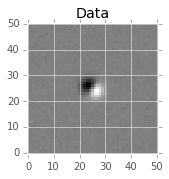

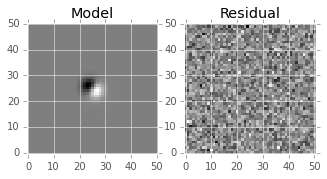

In [4]:
x, y, z = genDipole(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=324., 
                flux=3000., noise=1., display=True)
%timeit fitDipole(z, psfWidth=2., verbose=False, display=False)
result = fitDipole(z, psfWidth=2., verbose=True, display=True)

In [5]:
result = genDipoleAndFitIt(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=0.,
                              flux=3000., noise=1., verbose=False, display=False)
results = result.best_values
print results

centroid = ((results['xcenPos']+results['xcenNeg'])/2., (results['ycenPos']+results['ycenNeg'])/2.)
print 'CENTROID:', centroid

dx, dy = results['xcenPos']-results['xcenNeg'], results['ycenPos']-results['ycenNeg']
angle = np.arctan2(dy, dx) / np.pi * 180.
print 'ANGLE:', angle

## Note this (conf interval computation) takes too long. Let's use estimated uncertainties from the model fit
#ci = lmfit.conf_interval(result, result, sigmas=[0.68, 0.95])
#lmfit.printfuncs.report_ci(ci)

# This is how we get out the errors in the parameters from the fit:
#for pname, par in result.params.items():
#    print pname, par.value, par.stderr    

fluxVal, fluxErr = result.params['flux'].value, result.params['flux'].stderr
#signalToNoise = np.sqrt((fluxVal/fluxErr)**2 + (fluxVal/fluxErr)**2) ## This is from DipoleAnalysis code
signalToNoise = np.sqrt(2.) * fluxVal/fluxErr
print 'S/N:', signalToNoise

{'ycenPos': 25.002294834554053, 'flux': 2891.8929291635891, 'xcenPos': 26.044732514846743, 'psfWidth': 2.0, 'xcenNeg': 23.954176669091449, 'ycenNeg': 25.007035586819256}
CENTROID: (24.999454591969098, 25.004665210686653)
ANGLE: -0.129929382876
S/N: 45.4361959741


In [6]:
def detectDipoleSources(z, psfWidth, noise=1., detectSigma=5.0, grow=1, verbose=False, display=False):
    # Detect positive and negative sources in the image. 
    # See meas_algorithms/python/lsst/meas/algorithms/detection.py (SourceDetectionConfig) for config params
    
    w, h = z.shape
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = z
    # Set variance to 1.0 -- TODO, should set variance after adding flux
    var   = image.getVariance()
    var.set(noise)

    exposure = afwImage.makeExposure(image)
    #exposure.setPsf(psf)
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    config.nSigmaToGrow = psfWidth
    config.thresholdValue = detectSigma ##5.0   ## how do we set the detection threshold? Default is 5 sigma, set via config.thresholdValue
    schema = afwTable.SourceTable.makeMinimalSchema()  
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exposure, sigma=psfWidth)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    #if verbose: print len(results.sources)

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Original image")
        plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')

        ## first overlay the pos and neg fp centers on the input image and show it.
        for fp in results.fpSets.positive.getFootprints():
            for pk in fp.getPeaks():
                plt.plot(pk.getIx(), pk.getIy(), 'rx')
        for fp in results.fpSets.negative.getFootprints():
            for pk in fp.getPeaks():
                plt.plot(pk.getIx(), pk.getIy(), 'bx')
    
    # Merge them together
    assert(len(results.sources) >= 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, grow, grow, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) >= 1)
    
    s = sources[0]
    if verbose:
        print 'N SOURCES:', len(sources)
        for ss in sources: 
            print len(ss.getFootprint().getPeaks())
            if len(ss.getFootprint().getPeaks()) == 2:
                s = ss
            for pk in ss.getFootprint().getPeaks():
                print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()
    
    assert(len(s.getFootprint().getPeaks()) == 2)

    if verbose:
        for pk in s.getFootprint().getPeaks():
            print 'FINAL FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Original image")
        plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        #plt.plot(xp, yp, 'bx')
        #plt.plot(xn, yn, 'bx')

        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIx(), pk.getIy(), 'rx')

        plt.subplot(1, 3, 2)
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(mask_arr, origin='lower', vmin=-100, vmax=100, cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIx(), pk.getIy(), 'rx')
        
    return s

N SOURCES: 1
2
FOOTPRINT CENTER: 23 27
FOOTPRINT CENTER: 27 23
FINAL FOOTPRINT CENTER: 23 27
FINAL FOOTPRINT CENTER: 27 23
[26 23] [24 27]
27.0 23.0
[ 23.  27.]
23.0 27.0


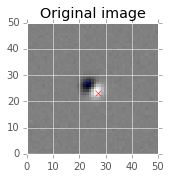

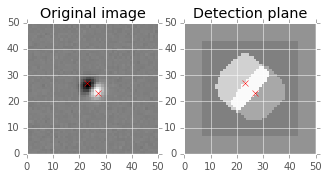

In [7]:
s = detectDipoleSources(z, psfWidth=2., noise=1., verbose=True, display=True)
#for pk in s.getFootprint().getPeaks():
#    print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()
    
maxPos = np.array(np.unravel_index(np.argmax(z), (51,51)))
minPos = np.array(np.unravel_index(np.argmin(z), (51,51)))
print minPos, maxPos

tmp = s.getFootprint().getPeaks()[0].getF()
print tmp[0], tmp[1]
print np.array(tmp)[::-1]

tmp = s.getFootprint().getPeaks()[1].getF()
print tmp[0], tmp[1]

### NOW: use detected source peaks as input positive/negative centroids

## Redefine `fitDipole()` to use centroids from detected source peaks

In [8]:
def fitDipole(z, psfWidth=2., cenPos=None, cenNeg=None, verbose=False, display=False):
    """fitDipole(z, psfWidth=2., verbose=False, display=False, cenPos=None, cenNeg=None))
        Starting centroids may be provided as tuple/array coordinates of centroids of positive and negative lobes.
        If these are None, then assume they are the max/min of the stamp.
    """
    w, h = z.shape
    y, x = np.mgrid[:w, :h]
    z = z.ravel()
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]

    ## For close/faint dipoles the starting locs (min/max) might be way off, let's help them a bit:
    centroidRange = psfWidth * 3.
    if cenPos is None:
        cenPos = np.array(np.unravel_index(np.argmax(z), (w,h)))
    ## Note - this may be a cheat to assume the dipole is centered in center of the stamp.
    if np.sum(np.sqrt((np.array(cenPos) - np.array([w/2, h/2]))**2.)) > centroidRange:
        cenPos = np.array([w/2., h/2.])
    if cenNeg is None:
        cenNeg = np.array(np.unravel_index(np.argmin(z), (w,h)))
    if np.sum(np.sqrt((np.array(cenNeg) - np.array([w/2, h/2]))**2.)) > centroidRange:
        cenNeg = np.array([w/2., h/2.])

    gmod = lmfit.Model(dipoleFunc, verbose=verbose)
    startingFlux = np.abs(z).sum() #/ sep * psfWidth #z.ptp() / 2.  ## ptp = max-min
    
#     if   minPos[0] < xc-centroidRange: minPos[0] = xc-centroidRange
#     elif minPos[0] > xc+centroidRange: minPos[0] = xc+centroidRange
#     if   minPos[1] < yc-centroidRange: minPos[1] = yc-centroidRange
#     elif minPos[1] > yc+centroidRange: minPos[1] = yc+centroidRange
#     if   maxPos[0] < xc-centroidRange: maxPos[0] = xc-centroidRange
#     elif maxPos[0] > xc+centroidRange: maxPos[0] = xc+centroidRange
#     if   maxPos[1] < yc-centroidRange: maxPos[1] = yc-centroidRange
#     elif maxPos[1] > yc+centroidRange: maxPos[1] = yc+centroidRange

    ## parameter hints/constraints: https://lmfit.github.io/lmfit-py/model.html#model-param-hints-section
    gmod.set_param_hint('xcenPos', value=cenPos[0], min=cenPos[0]-centroidRange, max=cenPos[0]+centroidRange)
    gmod.set_param_hint('ycenPos', value=cenPos[1], min=cenPos[1]-centroidRange, max=cenPos[1]+centroidRange)
    gmod.set_param_hint('xcenNeg', value=cenNeg[0], min=cenNeg[0]-centroidRange, max=cenNeg[0]+centroidRange)
    gmod.set_param_hint('ycenNeg', value=cenNeg[1], min=cenNeg[1]-centroidRange, max=cenNeg[1]+centroidRange)
    gmod.set_param_hint('flux', value=startingFlux, min=0.1, max=startingFlux * 2.)  ## TBD: higher flux limit? 
    gmod.set_param_hint('psfWidth', value=psfWidth, vary=False)
        
    result = gmod.fit(z, x=in_x, flux=startingFlux, xcenPos=cenPos[0], ycenPos=cenPos[1], 
                      xcenNeg=cenNeg[0], ycenNeg=cenNeg[1], verbose=verbose) #, sig1=1., sig2=2.)
    
    if verbose: 
        print(result.fit_report(show_correl=False))
        ## This is how to get confidence intervals out, see here: https://lmfit.github.io/lmfit-py/confidence.html and 
        ##    here: http://cars9.uchicago.edu/software/python/lmfit/model.html
        ## Note this calc takes a long time (longer than the fit!)
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 2)
        plt.imshow(result.best_fit.reshape(w, h), origin='lower', interpolation='none', cmap='gray')#, vmin=-zptp, vmax=zptp)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(z.reshape(w, h) - result.best_fit.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
        plt.title("Residual")
        
    return result

def genDipoleAndFitIt(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0., flux=100., 
                        noise=1., verbose=False, display=False):
    _, _, z = genDipole(w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                        flux=flux, noise=noise, display=display)
    
    pk1 = pk2 = None
    try:
        s = detectDipoleSources(z, psfWidth=psfWidth, noise=noise, verbose=verbose, display=display)
        pks = s.getFootprint().getPeaks()
        pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
        pk2 = pks[1].getF() #)[::-1]
    except AssertionError:
        #print 'HERE', flux, separation
        pass

    #print separation, flux, np.abs(z).sum()
    result = fitDipole(z, psfWidth=psfWidth, cenPos=pk1, cenNeg=pk2, verbose=verbose, display=display)
    return result #.best_values

N SOURCES: 1
2
FOOTPRINT CENTER: 25 28
FOOTPRINT CENTER: 25 22
FINAL FOOTPRINT CENTER: 25 28
FINAL FOOTPRINT CENTER: 25 22
 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "psfWidth"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "psfWidth"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 87
    # data points      = 2601
    # variables        = 5
    chi-square         = 2557.535
    reduced chi-square = 0.985
[[Variables]]
    xcenPos:    25.9996580 +/- 0.038284 (0.15%) (init= 28)
    ycenPos:    24.9886851 +/- 0.011537 (0.05%) (init= 25)
    xcenNeg:    24.0006734 +/- 0.038284 (0.16%) (init= 22)
    ycenNeg:    24.9977525 +/- 0.011536 (0.05%) (init= 25)
    flux:       

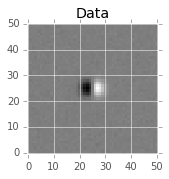

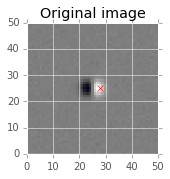

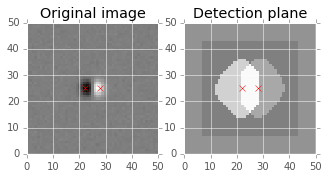

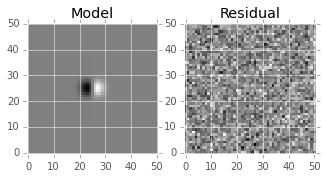

In [9]:
result = genDipoleAndFitIt(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=0.,
                              flux=3000., noise=1., verbose=True, display=True)
results = result.best_values
print results

centroid = ((results['xcenPos']+results['xcenNeg'])/2., (results['ycenPos']+results['ycenNeg'])/2.)
print 'CENTROID:', centroid

dx, dy = results['xcenPos']-results['xcenNeg'], results['ycenPos']-results['ycenNeg']
angle = np.arctan2(dy, dx) / np.pi * 180.
print 'ANGLE:', angle

## Note this (conf interval computation) takes too long. Let's use estimated uncertainties from the model fit
#ci = lmfit.conf_interval(result, result, sigmas=[0.68, 0.95])
#lmfit.printfuncs.report_ci(ci)

# This is how we get out the errors in the parameters from the fit:
#for pname, par in result.params.items():
#    print pname, par.value, par.stderr    

fluxVal, fluxErr = result.params['flux'].value, result.params['flux'].stderr
#signalToNoise = np.sqrt((fluxVal/fluxErr)**2 + (fluxVal/fluxErr)**2) ## This is from DipoleAnalysis code
signalToNoise = np.sqrt(2.) * fluxVal/fluxErr
print 'S/N:', signalToNoise

In [10]:
varNames = genDipoleAndFitIt.__code__.co_varnames[:genDipoleAndFitIt.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

#orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=0., 
                    flux=3000., noise=1., verbose=False, display=False) for i in xrange(10) for sep in separations]

def processInput(i):
    #print i.separation #, i.rotAngle
    output = genDipoleAndFitIt(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, display=False)
    output = output.best_values
    output['separation'] = i.separation
    output['inputCentroidPos'] = (i.xc+i.separation/2., i.yc+i.separation/2.)
    output['inputCentroidNeg'] = (i.xc-i.separation/2., i.yc-i.separation/2.)
    return output

num_cores = multiprocessing.cpu_count() / 2
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

/Users/dreiss/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


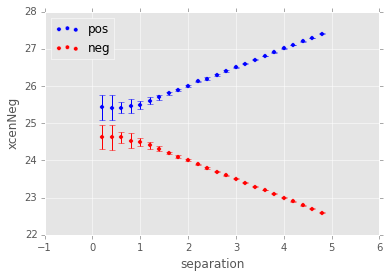

In [11]:
df = pd.DataFrame(results)
#sizeme(df)

tmp_df = df.groupby('separation').mean()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').std() * 1.
ax = tmp_df.plot(x='separation', y='xcenPos', kind='scatter', yerr=tmp_df2['xcenPos'], color='blue', label='pos')
tmp_df.plot(x='separation', y='xcenNeg', kind='scatter', yerr=tmp_df2['xcenNeg'], color='red', label='neg', ax=ax)

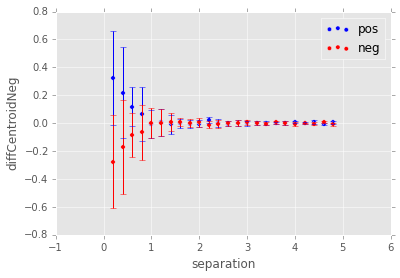

In [12]:
df['diffCentroidPos'] = df.xcenPos.values - np.array([i[0] for i in df.inputCentroidPos])
df['diffCentroidNeg'] = df.xcenNeg.values - np.array([i[0] for i in df.inputCentroidNeg])

tmp_df = df.groupby('separation').mean()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').std() * 1.
ax = tmp_df.plot(x='separation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='separation', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], color='red', label='neg', ax=ax)

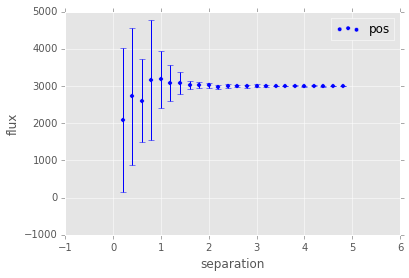

In [13]:
tmp_df = df.groupby('separation').mean()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').std() * 1.
ax = tmp_df.plot(x='separation', y='flux', kind='scatter', yerr=tmp_df2['flux'], color='blue', label='pos')
#tmp_df.plot(x='separation', y='flux', kind='scatter', yerr=tmp_df2['flux'], color='red', label='neg', ax=ax)

Try it again, this time setting different orientations as well. Next time we'll also test it as a function of scaling (source flux).

### Different orientations

In [14]:
varNames = genDipoleAndFitIt.__code__.co_varnames[:genDipoleAndFitIt.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=rot, 
                    flux=3000., noise=1., verbose=False, display=False) for rot in orientations for sep in separations]

def processInput(i):
    #print i.separation, i.rotAngle
    output = genDipoleAndFitIt(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, display=False)
    output = output.best_values
    output['separation'] = i.separation
    rotAngRad = i.rotAngle / 180. * np.pi
    sep = i.separation / 2.
    output['inputCentroidPos'] = (i.xc+sep*np.cos(rotAngRad), i.yc+sep*np.sin(rotAngRad))
    output['inputCentroidNeg'] = (i.xc-sep*np.cos(rotAngRad), i.yc-sep*np.sin(rotAngRad))
    output['rotAngle'] = i.rotAngle
    return output

    z = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)) #, psfWidth, psfWidth*1.75)
 

num_cores = multiprocessing.cpu_count() / 2
results2 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

In [15]:
df = pd.DataFrame(results2)
print df.shape
df['rmsCentroidPos'] = np.sqrt((np.array([i[0] for i in df.inputCentroidPos]) - df.xcenPos.values)**2. + \
                               (np.array([i[1] for i in df.inputCentroidPos]) - df.ycenPos.values)**2.)
df['rmsCentroidNeg'] = np.sqrt((np.array([i[0] for i in df.inputCentroidNeg]) - df.xcenNeg.values)**2. + \
                               (np.array([i[1] for i in df.inputCentroidNeg]) - df.ycenNeg.values)**2.)
sizeme(df[df.rmsCentroidPos>1].tail())

(240, 10)


,flux,inputCentroidNeg,inputCentroidPos,psfWidth,rotAngle,separation,xcenNeg,xcenPos,ycenNeg,ycenPos,rmsCentroidPos,rmsCentroidNeg


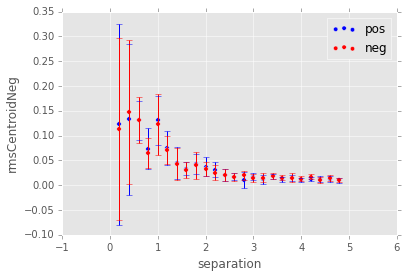

In [16]:
tmp_df = df.groupby('separation').median()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').mad() * 1.
ax = tmp_df.plot(x='separation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='separation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

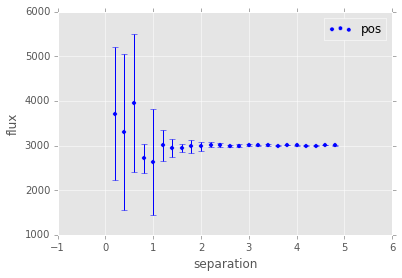

In [17]:
tmp_df = df.groupby('separation').median()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').mad() * 1.
ax = tmp_df.plot(x='separation', y='flux', kind='scatter', yerr=tmp_df2['flux'], color='blue', label='pos')

## Different dipole fluxes (signal-to-noise)

In [18]:
varNames = genDipoleAndFitIt.__code__.co_varnames[:genDipoleAndFitIt.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
fluxes = np.arange(250., 6000., 250.)

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=rot, 
                    flux=flux, noise=1., verbose=False, display=False) 
                      for flux in fluxes for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    #print i.flux #i.separation, i.rotAngle
    output = genDipoleAndFitIt(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, display=False)
    output = output.best_values
    output['separation'] = i.separation
    rotAngRad = i.rotAngle / 180. * np.pi
    sep = i.separation / 2.
    output['inputCentroidPos'] = (i.xc+sep*np.cos(rotAngRad), i.yc+sep*np.sin(rotAngRad))
    output['inputCentroidNeg'] = (i.xc-sep*np.cos(rotAngRad), i.yc-sep*np.sin(rotAngRad))
    output['inputFlux'] = i.flux
    output['rotAngle'] = i.rotAngle
    return output

    z = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)) #, psfWidth, psfWidth*1.75)
 
num_cores = multiprocessing.cpu_count() / 2
results3 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

5520


In [19]:
df = pd.DataFrame(results3)
df['rmsCentroidPos'] = np.sqrt((np.array([i[0] for i in df.inputCentroidPos]) - df.xcenPos.values)**2. + \
                               (np.array([i[1] for i in df.inputCentroidPos]) - df.ycenPos.values)**2.)
df['rmsCentroidNeg'] = np.sqrt((np.array([i[0] for i in df.inputCentroidNeg]) - df.xcenNeg.values)**2. + \
                               (np.array([i[1] for i in df.inputCentroidNeg]) - df.ycenNeg.values)**2.)

## Filter out bad values where the fit was obviously bad -- TBD - throw an error upstream instead.
print df.shape, df[df.flux < 90000.].shape
df = df[df.flux < 90000.]
sizeme(df[df.flux > 80000.].head())

(5520, 13) (5520, 13)


,flux,inputCentroidNeg,inputCentroidPos,inputFlux,psfWidth,rotAngle,separation,xcenNeg,xcenPos,ycenNeg,ycenPos,rmsCentroidPos,rmsCentroidNeg


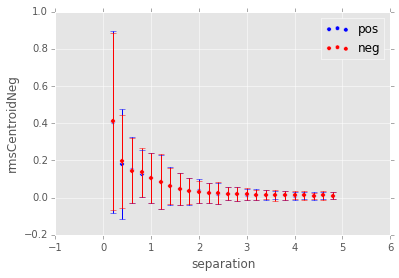

In [20]:
tmp_df = df.groupby('separation').median()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').mad() * 1.
ax = tmp_df.plot(x='separation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='separation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

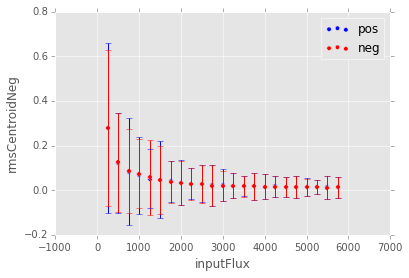

In [21]:
tmp_df = df.groupby('inputFlux').median()
tmp_df['inputFlux'] = tmp_df.index.values
tmp_df2 = df.groupby('inputFlux').mad() * 1.
ax = tmp_df.plot(x='inputFlux', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='inputFlux', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

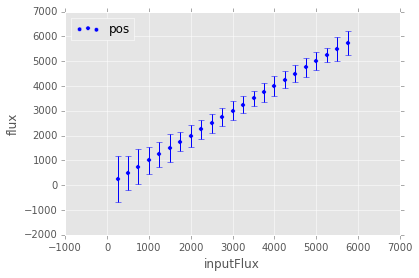

In [22]:
tmp_df = df.groupby('inputFlux').median()
tmp_df['inputFlux'] = tmp_df.index.values
tmp_df2 = df.groupby('inputFlux').mad() * 1.
ax = tmp_df.plot(x='inputFlux', y='flux', kind='scatter', color='blue', label='pos', yerr=tmp_df2['flux'])